# Flux measurement of Meteors in AARTFAAC-12

- Use catalogues to get a flux scale across the observing range, then scale the images
    - 8C catalogue, VLSSr, Scaife & heald, Aries et al. 
- Figure out a way to get flux measurements across the frequency range



In [1]:
import numpy as np
import pandas as pd 
import xarray as xr
import bdsf
import matplotlib
%matplotlib inline 
import matplotlib.pyplot as plt 
from astropy.visualization import ZScaleInterval
from scipy.optimize import curve_fit


import h5py
import glob
import os
import time 
from scipy import interpolate

from astropy.wcs import WCS
from astropy.io import fits
from astropy import units as u
from astropy.coordinates import SkyCoord
import pylab 

plt.rcParams['font.size'] = 16
plt.rcParams['axes.labelsize'] = 'large'
plt.rcParams['axes.titlesize'] = 'large'
pylab.rcParams['legend.loc'] = 'best'
matplotlib.rcParams['text.usetex'] = False



np.seterr(divide="ignore")

{'divide': 'raise', 'invalid': 'warn', 'over': 'warn', 'under': 'ignore'}

In [15]:
def powlaw(x,a,b):
    return a*x**b 


def get_freq(SB):
    '''
    Return the LOFAR subband of a given frequency, for LBA.
    Input: Subband
    Output: MHz (float) 
    '''
    return (SB/512.)*200./2.

def get_beam(freq):
    beams = np.array([30,35,40,50,55,60,65,70,75,80,85,90])
    freq_to_use = str(beams[np.argsort(np.abs(freq-beams))[0]])

    beam_file = "/home/mkuiack1/AARTFAAC_beamsim/LBAOUTER_AARTFAAC_beamshape_{}MHz.hdf5".format(freq_to_use)
    orig =  np.array(h5py.File(beam_file, mode="r").get('lmbeamintensity_norm'))

    # Make its coordinates; x is horizontal.
    x = np.linspace(0, 2300, orig.shape[1])
    y = np.linspace(0, 2300, orig.shape[0])

    # Make the interpolator function.
    f = interpolate.interp2d(x, y, orig, kind='linear')

    # Construct the new coordinate arrays.
    x_new = np.arange(0, 2300)
    y_new = np.arange(0, 2300)

    # Do the interpolation.
    return f(x_new, y_new)


def scaif_spectra(freq, a):
    result=1
    for i in range(len(a)):
        if i == 0:
            result*=a[i]
        else:
            result*=10**(a[i]*np.log10(freq/150.)**i)
            
    return result

In [3]:
# plt.plot([30,40,50,60,70], 
#          52.3*(np.array([30,40,50,60,70])/1000.)**(-0.63), 
#         label="PL: Arias et al. 2019")
Tycho_spectra = interpolate.interp1d([30,40,50,60,70], 
                                     52.3*(np.array([30,40,50,60,70])/1000.)**(-0.63) )

In [4]:
subbands = np.array([156, 165, 174, 187, 195, 213, 221, 231,
                     243, 256, 257, 267, 278, 284, 296, 320])

In [5]:
OBS = "202012131800"
SLICE = "2020-12-13T18:32:01-18:35:11"
SB = "SB{}".format(subbands[5])

file_path = "/opt/Archive/{}/{}_all/{}-{}/imgs/2020-12-13T18:33:34.*-{}.fits".format(OBS,SLICE,SB,SLICE,SB)

In [6]:
bg_files = glob.glob("/opt/Archive/{}/{}_all/{}-{}/imgs/*{}.fits".format(OBS,SLICE,SB,SLICE,SB))
print len(bg_files)

bg_stack = []

for bg_file in bg_files[:30]:

        try:
            bg_data, bg_f =fits.getdata(bg_file, header=True)
        except IOError:
            print "IOError", bg_file
            continue



        beam_model = get_beam(bg_f[" CRVAL3"]/1e6)
        STD = np.std(bg_data)
        
        if STD < 80. and STD > 3.:
            bg_stack.append(bg_data[0,0,:,:]*(np.max(beam_model)/beam_model))


189


[array(1163.43245645), array(1379.17518473)]
3c48 [array(876.86185551), array(799.94172292)]
3c147 [array(427.91963029), array(1557.52093908)]
3c380 [array(1905.58468288), array(1678.32112028)]


/home/mkuiack1/env/lib/python2.7/site-packages/numpy/core/_methods.py:75: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)


Text(1905.58,1678.32,'3C380')

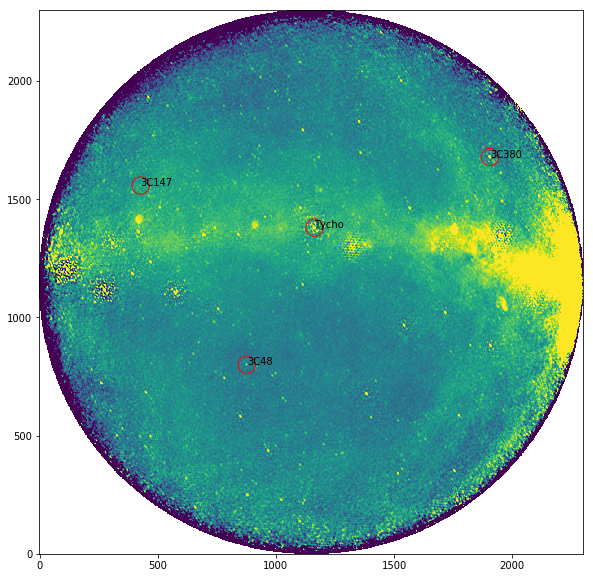

In [7]:

bg_img = np.median(bg_stack, axis=0)
vmin, vmax= ZScaleInterval(contrast=0.4).get_limits(bg_img)

wcs = WCS(bg_f)
wcs = wcs.dropaxis(-1).dropaxis(-1)


plt.figure(figsize=(10,10))
# plt.subplot(projection=wcs)
plt.imshow(bg_img, 
           vmin=vmin,
           vmax=vmax, origin="lower" )
spot = wcs.wcs_world2pix(6.3395833,    64.1408056, 0)

print spot
plt.scatter(spot[0],spot[1],  facecolor="none", color="r", s=300)
plt.text(spot[0],spot[1],"Tycho" )

spot = wcs.wcs_world2pix(24.4220833,   33.1597222, 0)
print "3c48", spot
plt.scatter(spot[0],spot[1],  facecolor="none", color="r", s=300)
plt.text(spot[0],spot[1],"3C48" )


spot = wcs.wcs_world2pix(85.6504167,    49.8519444 , 0)
print "3c147", spot
plt.scatter(spot[0],spot[1],  facecolor="none", color="r", s=300)
plt.text(spot[0],spot[1],"3C147" )

spot = wcs.wcs_world2pix(277.3825000, 48.7461111, 0)
print "3c380", spot
plt.scatter(spot[0],spot[1],  facecolor="none", color="r", s=300)
plt.text(spot[0],spot[1],"3C380")
# 6.3395833    64.1408056 -pix 1163 1379

In [8]:
ycoord, xcoord =np. mgrid[0:2300,0:2300]

In [9]:
raw_tycho_flux = np.sum(bg_img[np.sqrt((xcoord - spot[0])**2 + (ycoord - spot[1])**2)  < 10])
flux_scale = Tycho_spectra(bg_f["RESTFRQ"]/1e6)/raw_tycho_flux

print raw_tycho_flux, Tycho_spectra(bg_f["RESTFRQ"]/1e6)


23957.313239489653 389.0315839908883


In [82]:
ycoord, xcoord =np. mgrid[0:2300,0:2300]


# Tycho [array(1163.43245645), array(1379.17518473)]
# 3c48 [array(876.86185551), array(799.94172292)]
# 3c147 [array(427.91963029), array(1557.52093908)]
# 3c380 [array(1905.58468288), array(1678.32112028)]

#tycho
# xmin,xmax = 1050, 1250
# ymin,ymax = 1250, 1450
#3c48
# ymin,ymax = 699, 899
# xmin,xmax = 776, 976

#3c380
# ymin,ymax = 1578, 1778
# xmin,xmax = 1805, 2005

# # 3c147
# ymin,ymax = 1457, 1657
# xmin,xmax = 327, 527

#MRA
ymin,ymax = 650, 1000
xmin,xmax = 1350, 1900

length = ymax-ymin
height = xmax-xmin

all_stamps = np.zeros([16,length,height])

for i in range(len(subbands)):
    tstart=time.time()
    SB = "SB{}".format(subbands[i])
               
    print SB
    
    bg_files = glob.glob("/opt/Archive/{}/{}_all/{}-{}/imgs/*{}.fits".format(OBS,SLICE,SB,SLICE,SB))

    bg_stack = []

    for bg_file in bg_files[:30]:

            try:
                bg_data, bg_f =fits.getdata(bg_file, header=True)
            except IOError:
                print "IOError", bg_file
                continue



            beam_model = get_beam(bg_f[" CRVAL3"]/1e6)
            STD = np.std(bg_data)

            if STD < 80. and STD > 3:
                bg_stack.append(bg_data[0,0,:,:]*(np.max(beam_model)/beam_model))
    
    wcs = WCS(bg_f)
    wcs = wcs.dropaxis(-1).dropaxis(-1)
    tychocoord = wcs.wcs_world2pix(6.3395833,    64.1408056, 0)
    
    bg_img = np.median(bg_stack, axis=0)
    try: 
        raw_tycho_flux = np.sum(bg_img[np.sqrt((xcoord - tychocoord[0])**2 +\
                                           (ycoord - tychocoord[1])**2)  < 10])
    except IndexError:
        continue 
        
    flux_scale = Tycho_spectra(bg_f["RESTFRQ"]/1e6)/raw_tycho_flux
               

    file_path = "/opt/Archive/{}/{}_all/{}-{}/imgs/2020-12-13T18:33:34.*-{}.fits"\
               .format(OBS,SLICE,SB,SLICE,SB)
    
    data, f = fits.getdata(glob.glob(file_path)[0], header=True)

    beam_model = get_beam(f[" CRVAL3"]/1e6)

    img  = data[0,0,:,:]*(np.max(beam_model)/beam_model)

    meteor_img = flux_scale*(img)

    all_stamps[i,:,:] = meteor_img[ymin:ymax,xmin:xmax]
    print '\t', time.time() - tstart


SB156
	15.8259489536
SB165
	14.5156080723
SB174
	15.1872010231
SB187
	14.8738000393
SB195
	14.2957451344
SB213
	16.0620470047
SB221
	13.9821858406
SB231
	14.9841229916
SB243
	14.6353261471
SB256
SB257
	15.6076200008
SB267
	15.2372350693
SB278
	13.3115160465
SB284
	12.5116250515
SB296
	12.4166390896
SB320
	11.5519399643


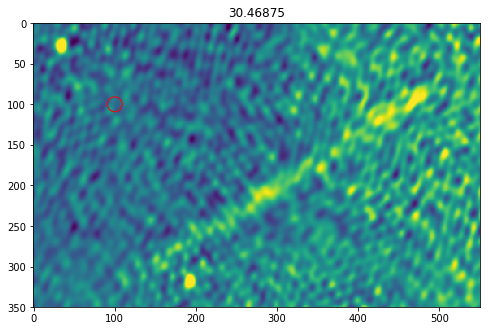

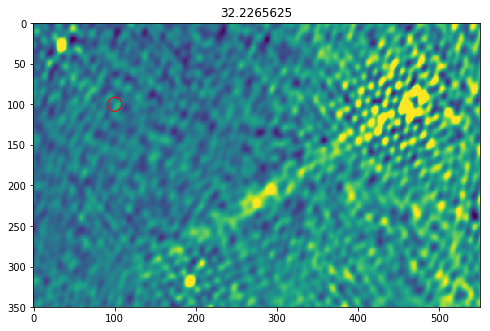

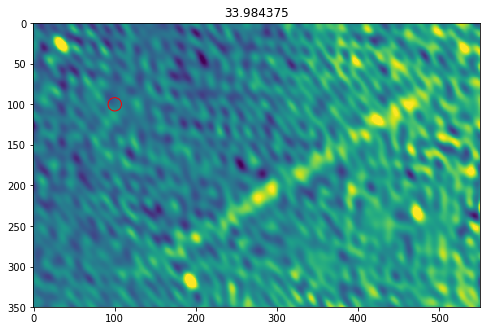

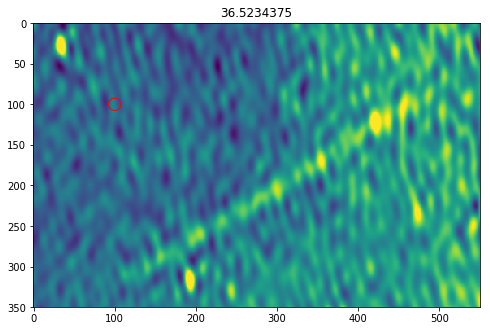

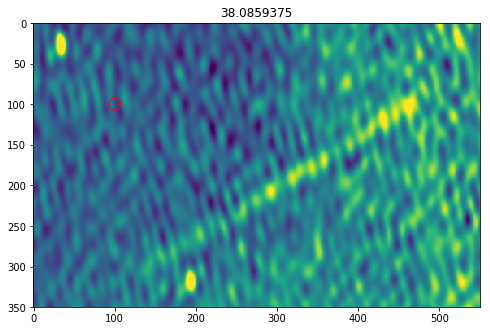

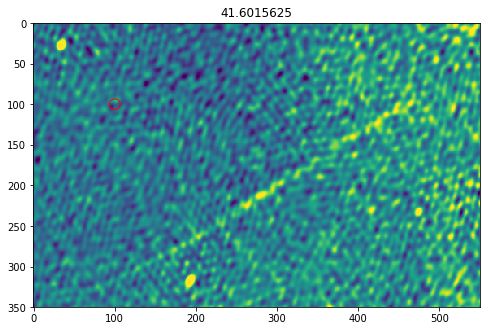

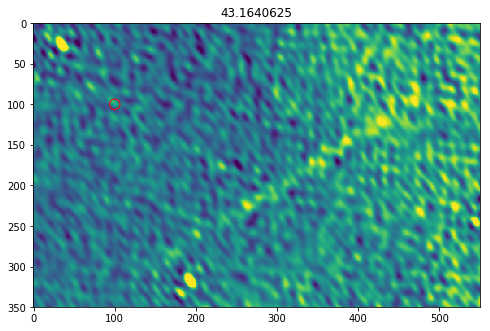

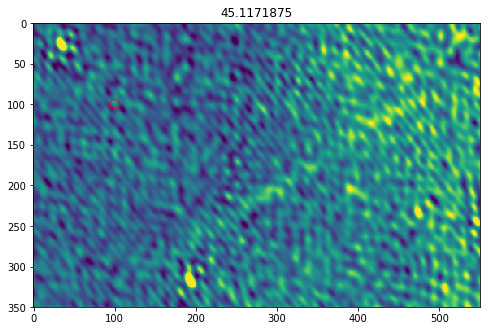

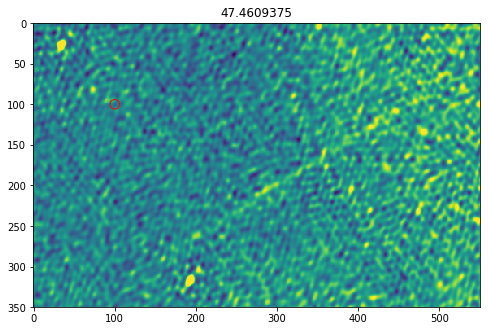

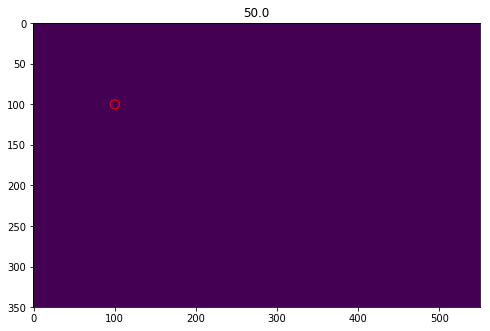

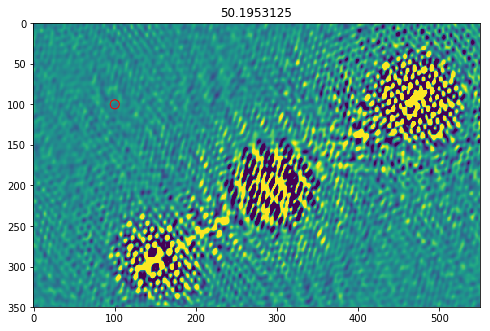

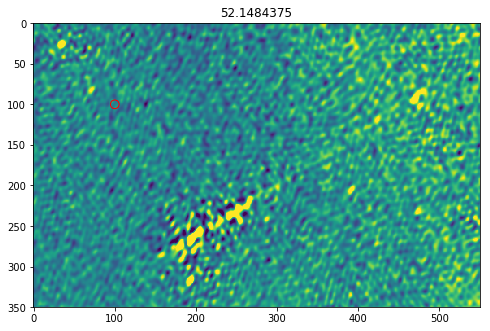

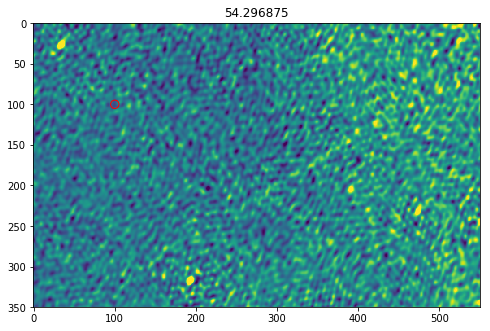

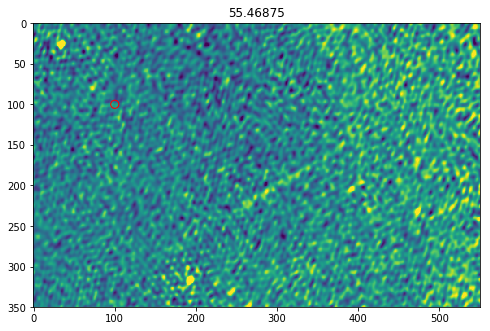

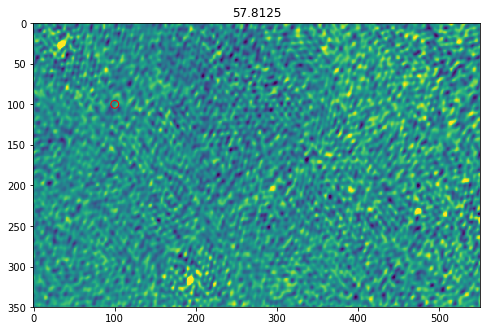

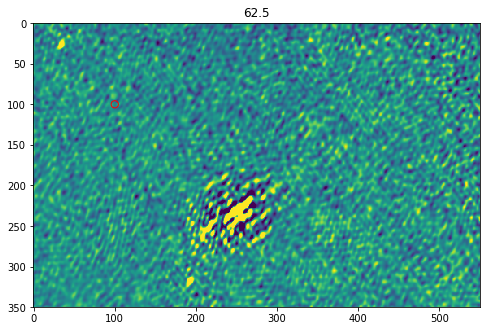

In [83]:
# print SB
# 290,205  alpha - 2


# tycho
# (112,130)

circ_sizes = 10/0.5*np.rad2deg(1.22*(wavelength/1500))

for i in range(16):
    vmin, vmax= ZScaleInterval(contrast=0.4).get_limits(all_stamps[i,:,:])

    plt.figure(figsize=(8,8))
    ax = plt.subplot(111)
    plt.title(get_freq(subbands[i]))
    plt.imshow(all_stamps[i,:,:], 
               vmin=vmin,
               vmax=vmax)
    
    circ = plt.Circle((100,100), circ_sizes[i], color='r', fill=False)
    ax.add_patch(circ)
#     plt.plot(115,130, marker="o", markersize=10)
#     plt.colorbar()

In [56]:
ycoord, xcoord =np. mgrid[0:length,0:height]
newspot = np.array([100,100])
bgspot = np.array([150,50])

-3.2703223449879886


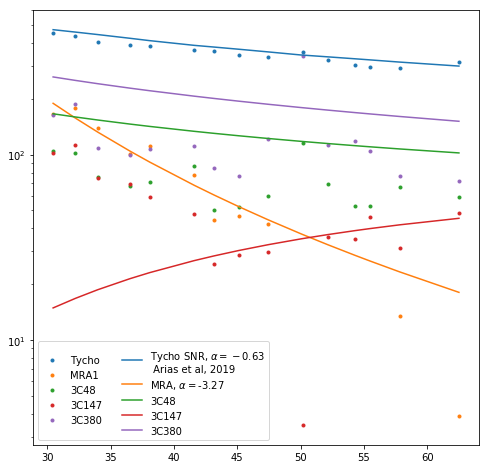

In [81]:
spectra = np.array([np.sum(all_stamps[i][np.sqrt((xcoord - newspot[0])**2 +\
                             (ycoord - newspot[1])**2)  < circ_sizes[i]]) for i in range(len(all_stamps))])

bg_spectra = np.array([np.sum(all_stamps[i][np.sqrt((xcoord - bgspot[0])**2 +\
                             (ycoord - bgspot[1])**2)  < circ_sizes[i]]) for i in range(len(all_stamps))])

plt.figure(figsize=(8,8))
# plt.plot(get_freq(subbands), spectra, ".")
for key in spectras.keys():
    plt.plot(spectras.index.astype(float),spectras[key], ".")

plt.plot(get_freq(subbands), Tycho_spectra(get_freq(subbands)),
         label=r"Tycho SNR, $\alpha = -0.63$""\n Arias et al, 2019", c="C0")

fit, cov = curve_fit(powlaw,
                     get_freq(subbands)[(np.array(spectras["MRA1"]) > 0)],
                     np.array(spectras["MRA1"])[(np.array(spectras["MRA1"]) > 0)])
print fit[1]
plt.plot(get_freq(subbands), fit[0]*get_freq(subbands)**fit[1], 
         label=r"MRA, $\alpha=$""{}".format(round(fit[1],2)), c="C1")

count = 2
for a, name in zip([[64.768, -0.387, 0.420, 0.181],
          [66.738, -0.022, -1.012, 0.549],
          [77.352, -0.767]], ["3C48","3C147","3C380"]):

    plt.plot(get_freq(subbands),
             scaif_spectra(get_freq(subbands), a), label=name, c="C"+str(count))
    count += 1
    
plt.legend(ncol=2)
plt.yscale("log")
# plt.xscale("log")

In [37]:

spectra = [np.sum(X[np.sqrt((xcoord - newspot[0])**2 +\
                  (ycoord - newspot[1])**2)  < 10]) for X in all_stamps]

fit, cov = curve_fit(powlaw,
                     get_freq(subbands)[(np.array(spectra) > 0)],
                     np.array(spectra)[(np.array(spectra) > 0)])


In [60]:
spectra

array([102.54110403, 112.77541287,  75.23254303,  69.07016886,
        59.36092781,  47.76390484,  25.75401275,  28.63378379,
        29.83269475,   0.        ,   3.46980904,  35.84436922,
        35.10005284,  45.94960199,  31.16088335,  48.37694429])

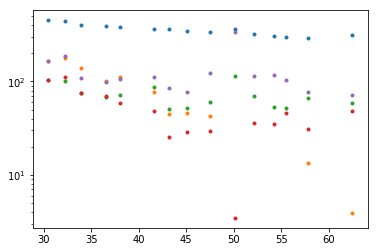

In [80]:
spectras = pd.read_csv("spectras.csv", index_col=0).T
for key in spectras.keys():
    plt.plot(spectras.index.astype(float),spectras[key], ".")
plt.yscale("log")

In [110]:
# 3c48
a = [64.768, -0.387, 0.420, 0.181]
# 3c147
a = [66.738, -0.022, -1.012, 0.549]
# 3c380
a = [77.352, -0.767]

def scaif_spectra(freq, a):
    result=1
    for i in range(len(a)):
        if i == 0:
            result*=a[i]
        else:
            result*=10**(a[i]*np.log10(freq/150.)**i)
            
    return result

In [19]:
wavelength = 299792458./ (get_freq(subbands)*1e6)

In [23]:
10/0.32*np.rad2deg(1.22*(wavelength/1500))

array([14.32871654, 13.54715018, 12.84643552, 11.95336781, 11.46297323,
       10.49427127, 10.11438815,  9.67653585,  9.19868222,  8.73156164,
        8.69758669,  8.37183438,  8.04057475,  7.87070345,  7.55162088,
        6.98524931])

In [109]:
all_stamps = np.zeros([16,350,550])

1434.1039626518832

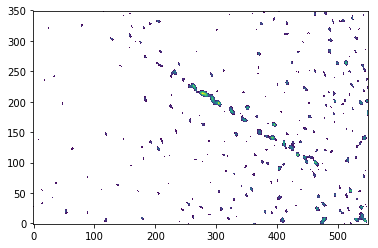

In [105]:
stamp = np.copy(meteor_img[650:1000,1350:1900])

not_meteor_loc = (stamp - np.mean(stamp)) < 2*np.std(stamp)
stamp[not_meteor_loc] *= np.nan
plt.imshow(stamp, origin="lower")

np.nansum(stamp)

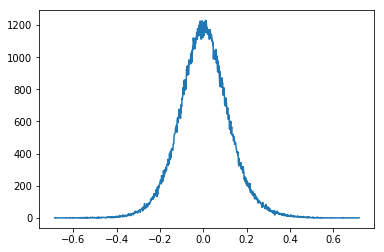

In [21]:
n,bins = np.histogram((time_img-bg_img)[650:1000,1350:1900], bins=1000)
plt.plot(bins[:-1],n)

In [130]:
hdul = fits.open("/home/mkuiack1/meteors/{}_SB{}.fits".format(prihdr["DATE-OBS"],SB))
prihdr = hdul[0].header

prihdr.update({'RESTFRQ':prihdr["RESTFRQ"]})
prihdr.update({'RESTFREQ':prihdr["RESTFREQ"]})
prihdr.update({'RESTBW':prihdr["RESTBW"]})
hdul[0].data[0,0,:,:][~np.isfinite(img-bg_img)] = 0

vmin, vmax= ZScaleInterval(contrast=0.4).get_limits(hdul[0].data[0,0,:,:])

plt.figure(figsize=(10,10))
plt.imshow(hdul[0].data[0,0,:,:], 
           vmin=vmin,
           vmax=vmax, origin="lower" )

IOError: [Errno 2] No such file or directory: '/home/mkuiack1/meteors/2020-12-13T18:33:32.4_SBSB320.fits'

In [88]:


print np.sum(np.isfinite(hdul[0].data[0,0,:,:]))
print len(np.ravel(hdul[0].data[0,0,:,:]))

5250977
5290000


In [97]:
# !mkdir /home/mkuiack1/meteors/

hdul = fits.open(file_path)
prihdr = hdul[0].header

prihdr.update({'RESTFRQ':prihdr["RESTFRQ"]})
prihdr.update({'RESTFREQ':prihdr["RESTFREQ"]})
prihdr.update({'RESTBW':prihdr["RESTBW"]})
hdul[0].data[0,0,:,:] = img-bg_img

# print "/home/mkuiack1/{}_nSB{}.fits".format(slice_times[0],int(len(all_freqs)))
hdul.writeto("/home/mkuiack1/meteors/{}_SB{}.fits".format(prihdr["DATE-OBS"],SB), overwrite=True)

/home/mkuiack1/env/lib/python2.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in subtract
  if __name__ == '__main__':


In [121]:
OBS = "202012131800"
SLICE = "2020-12-13T18:32:01-18:35:11"
SB = "SB{}".format(subbands[15])

file_path = "/opt/Archive/{}/{}_all/{}-{}/imgs/2020-12-13T18:33:32.4-{}.fits".format(OBS,SLICE,SB,SLICE,SB)

img_proc = bdsf.process_image(file_path, advanced_opts = True,thresh_pix=3,
                              trim_box=(1250,2000,700,1000), 
                              split_isl=False,)

--> Opened '/opt/Archive/202012131800/2020-12-13T18:32:01-18:35:11_all/SB320-2020-12-13T18:32:01-18:35:11/imgs/2020-12-13T18:33:32.4-SB320.fits'
Image size .............................. : (750, 300) pixels
Number of channels ...................... : 1
Number of Stokes parameters ............. : 1
Beam shape (major, minor, pos angle) .... : (2.00000e-01, 2.00000e-01, 0.0) degrees
Frequency of image ...................... : 62.500 MHz
Number of blank pixels .................. : 0 (0.0%)
Flux from sum of (non-blank) pixels ..... : -18485.626 Jy
--> Calculating background rms and mean images
Derived rms_box (box size, step size) ... : (75, 25) pixels
--> Variation in rms image significant
--> Using 2D map for background rms
--> Variation in mean image significant
--> Using 2D map for background mean
Min/max values of background rms map .... : (8.30e+00, 3.71e+01) Jy/beam
Min/max values of background mean map ... : (-8.71e+00, 3.61e+00) Jy/beam
--> Expected 5-sigma-clipped false detection 

Fitting islands with Gaussians .......... : [|--------------------------------------------------------] 0/57/Fitting islands with Gaussians .......... : [=/-------------------------------------------------------] 1/57-Fitting islands with Gaussians .......... : [==-------------------------------------------------------] 2/57Fitting islands with Gaussians .......... : [==-------------------------------------------------------] 2/57-|Fitting islands with Gaussians .......... : [====|----------------------------------------------------] 4/57||Fitting islands with Gaussians .......... : [====|----------------------------------------------------] 4/57Fitting islands with Gaussians .......... : [====|----------------------------------------------------] 4/57\\Fitting islands with Gaussians .......... : [=======\-------------------------------------------------] 7/57Fitting islands with Gaussians .......... : [=======\-------------------------------------------------] 7/57|/Fitting islands wi

Total number of Gaussians fit to image .. : 32
Total flux density in model ............. : 5622.619 Jy


--> Grouping Gaussians into sources
Number of sources formed from Gaussians   : 32
    Island #1 (x=21, y=35)
    Island #3 (x=56, y=228)
    Island #8 (x=182, y=85)
    Island #10 (x=245, y=243)
    Island #13 (x=287, y=219)
    Island #16 (x=326, y=199)
    Island #23 (x=418, y=238)
    Island #25 (x=441, y=193)
    Island #29 (x=547, y=52)
    Island #30 (x=555, y=72)
    Island #31 (x=556, y=34)
    Island #32 (x=562, y=37)
    Island #33 (x=565, y=20)
    Island #34 (x=565, y=46)
    Island #35 (x=573, y=41)
    Island #36 (x=569, y=27)
    Island #37 (x=575, y=53)
    Island #39 (x=579, y=172)
    Island #40 (x=579, y=33)
    Island #43 (x=588, y=18)
    Island #45 (x=592, y=25)
    Island #46 (x=593, y=48)
    Island #47 (x=598, y=77)
    Island #48 (x=598, y=28)
    Island #50 (x=615, y=28)
Please check these islands. If they are valid islands and
should be fit, try adjusting the flagging options (use
show_fit with "ch0_flagged=True" to see the flagged Gaussians)
or enabling th

NOTE -- With the mouse pointer in plot window:
  Press "i" ........ : Get integrated flux densities and mean rms
                       values for the visible portion of the image
  Press "m" ........ : Change min and max scaling values
  Press "n" ........ : Show / hide island IDs
  Press "0" ........ : Reset scaling to default
  Click Gaussian ... : Print Gaussian and source IDs (zoom_rect mode, 
                       toggled with the "zoom" button and indicated in 
                       the lower right corner, must be off)
________________________________________________________________________


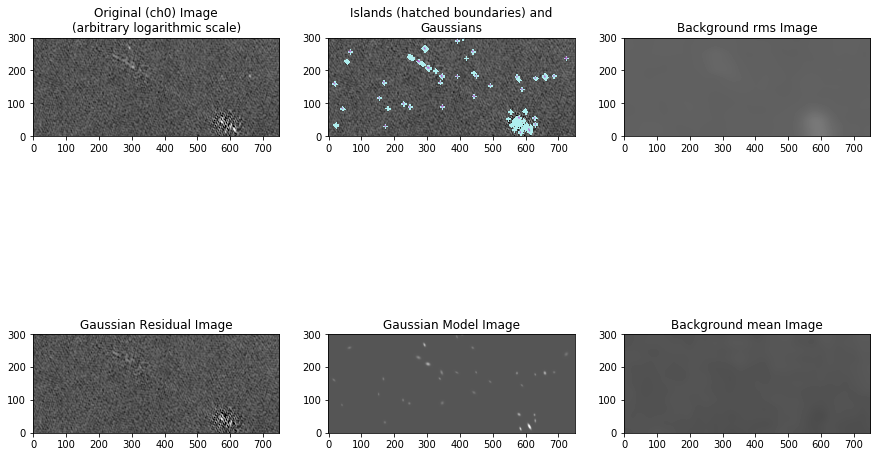

True

In [122]:
img_proc.show_fit()

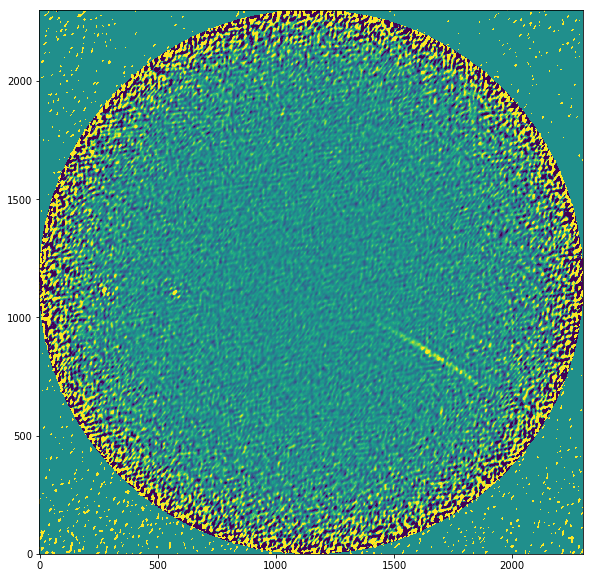

In [78]:
data, f = fits.getdata("/home/mkuiack1/meteors/{}_SB{}.fits".format(prihdr["DATE-OBS"],SB), header=True)

# beam_model = get_beam(f[" CRVAL3"]/1e6)

img  = data[0,0,:,:]#*(np.max(beam_model)/beam_model)

vmin, vmax= ZScaleInterval(contrast=0.4).get_limits(img)

plt.figure(figsize=(10,10))
plt.imshow(np.nan_to_num(img, 0), 
           vmin=vmin,
           vmax=vmax, origin="lower" )

## Make spectra

320


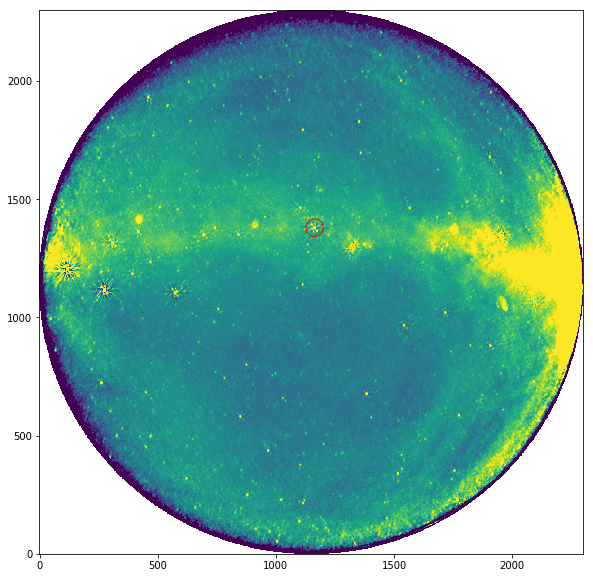

In [74]:
bg_files = glob.glob("/opt/Archive/{}/{}_all/*-{}/imgs/2020-12-13T18:33:[1,2]*.fits".format(OBS,SLICE,SLICE))
print len(bg_files)

bg_stack = []

for bg_file in bg_files:

        try:
            bg_data, bg_f =fits.getdata(bg_file, header=True)
        except IOError:
            print "IOError", bg_file
            continue

        beam_model = get_beam(bg_f[" CRVAL3"]/1e6)
        STD = np.std(bg_data[0,0,:,:])
        if STD < 80. and STD > 3.:
            bg_stack.append(bg_data[0,0,:,:]*(np.max(beam_model)/beam_model))


bg_img = np.median(bg_stack, axis=0)
vmin, vmax= ZScaleInterval(contrast=0.4).get_limits(bg_img)

wcs = WCS(bg_f)
wcs = wcs.dropaxis(-1).dropaxis(-1)


plt.figure(figsize=(10,10))
# plt.subplot(projection=wcs)
plt.imshow(bg_img, 
           vmin=vmin,
           vmax=vmax, origin="lower" )
spot = wcs.wcs_world2pix(6.3395833,    64.1408056, 0)
plt.scatter(spot[0],spot[1],  facecolor="none", color="r", s=300)




# 6.3395833    64.1408056

In [84]:
TIME = "2020-12-13T18:33:3[2,3].4"

time_files = glob.glob("/opt/Archive/{}/{}_all/*-{}/imgs/{}*.fits".format(OBS,SLICE,SLICE,TIME))
print len(time_files)

time_stack = []
for time_file in time_files:

        try:
            time_data, time_f =fits.getdata(time_file, header=True)
        except IOError:
            print "IOError", time_file
            continue

        STD = np.std(time_data[0,0,:,:])

        beam_model = get_beam(time_f[" CRVAL3"]/1e6)
        print STD
        if STD < 80. and STD > 3.:
            time_stack.append(time_data[0,0,:,:]*(np.max(beam_model)/beam_model))


32
22.32775
22.398172
14.23981
14.2844715
13.557712
14.177788
13.555139
13.527466
12.359597
12.328415
50.719208
50.636692
58.538036
58.38081
24.597134
24.526531
11.728829
11.725802
56.722027
56.598465
54.800117
54.8382
20.34108
20.3284
49.31765
50.026947
164.0356
27513.938
11.775533
11.736226
10.824399
10.81903


/home/mkuiack1/env/lib/python2.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in subtract
  after removing the cwd from sys.path.


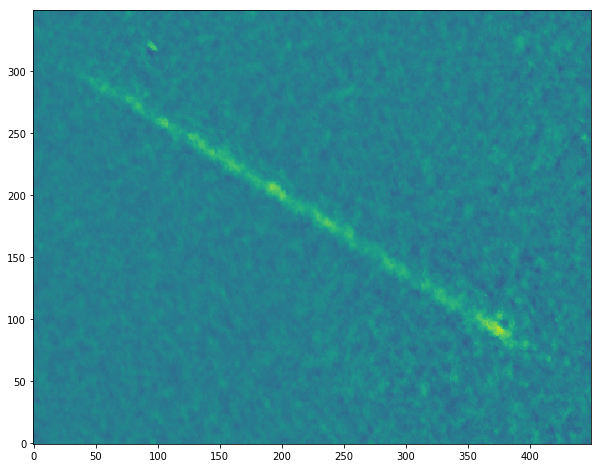

In [85]:
time_img = np.median(time_stack, axis=0)
vmin, vmax= ZScaleInterval(contrast=0.4).get_limits(time_img)
plt.figure(figsize=(10,10))
plt.imshow((time_img-bg_img)[650:1000,1450:1900], 
           vmin=vmin,
           vmax=vmax, origin="lower" )

/home/mkuiack1/env/lib/python2.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in subtract
  """Entry point for launching an IPython kernel.


128221.21475255744

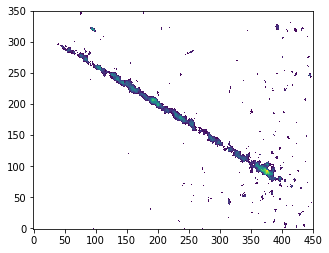

In [89]:
stamp = (time_img-bg_img)[650:1000,1450:1900]

not_meteor_loc = (stamp - np.mean(stamp)) < 2*np.std(stamp)
stamp[not_meteor_loc] *= np.nan
plt.imshow(stamp, origin="lower")

np.nansum(stamp)

In [42]:
not_meteor_loc

array([[ True,  True,  True, ..., False,  True,  True],
       [ True,  True,  True, ..., False, False,  True],
       [ True,  True,  True, ..., False, False,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

/home/mkuiack1/env/lib/python2.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in subtract
  """Entry point for launching an IPython kernel.


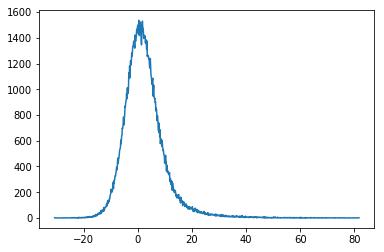

In [38]:
n,bins = np.histogram((time_img-bg_img)[650:1000,1350:1900], bins=1000)
plt.plot(bins[:-1], n)

In [ ]:

light_curves = pd.DataFrame([])
for im_num in np.arange(40,95,dtype=int):
    print im_num
    im_stack = get_stack(im_num, _pol="I")
    
    flux_vals =  [] 
    freq_count = 0
#     print im_num
    not_meteor_loc = np.abs(im_stack - np.mean(im_stack)) < 2*np.std(im_stack)
    print im_num, np.sum(~not_meteor_loc[int(im_y-100):int(im_y+100),int(im_x-100):int(im_x+100)])
    
    for im_file in sorted(glob.glob("/scratch/mkuiack/lookhere/2020-08-12T21:24:50-21:27:59/{}_*"
                                    .format(str(im_num).zfill(5)))):

        img_obj = fits.open(im_file)[0]
        wcs = WCS(img_obj.header)
        wcs = wcs.dropaxis(-1).dropaxis(-1)
        
        im_x, im_y = wcs.wcs_world2pix(238,15,0)
        
#         frame_std = np.std(img_obj.data[0,0,:,:])
         
#         clip_img = np.copy(img_obj.data[0,0,:,:])
        
#         not_meteor_loc = np.abs(im_stack - np.mean(im_stack)) < 2*np.std(im_stack)
#         clip_img[not_meteor_loc] *= np.nan
    
#         print np.nanmean(img_obj.data[0,0,:,:][int(im_y-100):int(im_y+100),
#                       int(im_x-100):int(im_x+100)][~not_meteor_loc[int(im_y-100):int(im_y+100),
#                                          int(im_x-100):int(im_x+100)]])/np.nanmean(img_obj.data[0,0,:,:][int(im_y-100):int(im_y+100),
#                       int(im_x-100):int(im_x+100)][not_meteor_loc[int(im_y-100):int(im_y+100),
#                                          int(im_x-100):int(im_x+100)]])
    
#         plt.figure()
#         plt.imshow(img_obj.data[0,0,:,:][int(im_y-100):int(im_y+100),
#                                          int(im_x-100):int(im_x+100)], 
#                    origin="lower")
        
#         plt.figure()
#         plt.imshow(clip_img[int(im_y-100):int(im_y+100),
#                             int(im_x-100):int(im_x+100)], 
#                    origin="lower")
        
        
#         plt.figure()
#         plt.imshow(im_stack[int(im_y-100):int(im_y+100),
#                     int(im_x-100):int(im_x+100)],origin="lower")  

#         plt.show()
        

        
        if np.std(img_obj.data[0,0,:,:]) < 100. and np.sum(~not_meteor_loc[int(im_y-100):int(im_y+100),int(im_x-100):int(im_x+100)])  > 10:
            flux_val = np.nanmean(img_obj.data[0,0,:,:][int(im_y-100):int(im_y+100),
                      int(im_x-100):int(im_x+100)][~not_meteor_loc[int(im_y-100):int(im_y+100),
                                         int(im_x-100):int(im_x+100)]])/np.nanmean(img_obj.data[0,0,:,:][int(im_y-100):int(im_y+100),
                      int(im_x-100):int(im_x+100)][not_meteor_loc[int(im_y-100):int(im_y+100),
                                         int(im_x-100):int(im_x+100)]])
            
            light_curves = light_curves.append(pd.DataFrame({freqs[freq_count]:flux_val}, 
                                                            index=[im_num]), sort=True)
            freq_count += 1
        else:

            light_curves = light_curves.append(pd.DataFrame({freqs[freq_count]:np.nan}, 
                                                            index=[im_num]), sort=True)
            freq_count += 1
            
            

        
        
light_curves = light_curves.groupby(by=light_curves.index).min()
            